In [1]:
from team_functions import dataPrep, getTeamRollingSeason

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [6]:
def mapTeamId(team_id):
    teams = ['ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
             'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA','MIL', 'MIN', 'NOP', 'NYK', 
             'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
    return teams.index(team_id) + 1

In [7]:
teams_df = pd.DataFrame([])
current_df = pd.DataFrame([])
for team_file in os.listdir('data/TeamsPrep'):
    team_id = team_file[:3]
    
    season = 4
    for year in [2020, 2021, 2022, 2023]:
        team_df = pd.read_excel(f'data/TeamsPrep/{team_file}', str(year))

        team_df['TeamID'] = mapTeamId(team_id)
        team_df['OppID'] = team_df['OppID'].apply(lambda x: mapTeamId(x))
        team_df['Season'] = season

        teams_df = pd.concat([teams_df, team_df])
        season -= 1
        
    team_df = pd.read_excel(f'data/CurrentSeason/{team_file}')
    
    roll_df = getTeamRollingSeason(team_df)
    prep_df = dataPrep(roll_df, 'Games')
    
    prep_df['TeamID'] = mapTeamId(team_id)
    prep_df['OppID'] = prep_df['OppID'].apply(lambda x: mapTeamId(x))
    prep_df['Season'] = 0
    
    current_df = pd.concat([current_df, prep_df])
    
teams_df = teams_df.reset_index(drop=True)
current_df = current_df.reset_index(drop=True)

In [8]:
X = pd.concat([teams_df, current_df]).reset_index(drop=True)
display(X)

y = X['Target']
X = X.drop(columns=['Target', 'Date'])

,Game,Date,Streak,Pts,Pace,eFG,TOV,ORB,FTR,ORT,...,OppORB,OppFTR,OppORT,Location,Target,Month,DayOfWeek,DaysOfRest,TeamID,Season
0,2,2019-10-25,-1.0,102.000000,95.300000,0.512000,12.900000,20.900000,0.176000,107.000000,...,21.200000,0.156000,101.200,1,1,10,4,3.0,14,4
1,3,2019-10-27,1.0,98.500000,96.000000,0.477000,12.800000,21.900000,0.198500,102.650000,...,21.250000,0.151500,109.650,1,1,10,6,2.0,14,4
2,4,2019-10-29,2.0,105.666667,97.166667,0.513333,12.400000,22.533333,0.171667,108.633333,...,21.266667,0.189333,100.600,1,1,10,1,2.0,14,4
3,5,2019-11-01,3.0,109.250000,100.100000,0.511500,13.025000,22.725000,0.224750,109.025000,...,20.375000,0.266500,113.775,0,1,11,4,3.0,14,4
4,6,2019-11-03,4.0,111.200000,99.980000,0.516400,12.320000,20.620000,0.213200,108.900000,...,25.960000,0.253200,112.620,0,1,11,6,2.0,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10419,40,2024-01-17,-2.0,112.717949,97.733333,0.531923,11.082051,23.443590,0.211333,114.538462,...,27.300000,0.207000,115.700,0,0,1,2,2.0,11,0
10420,41,2024-01-20,-3.0,112.250000,97.645000,0.530225,11.050000,23.190000,0.210800,114.170000,...,32.700000,0.162000,115.200,1,1,1,5,3.0,11,0
10421,42,2024-01-21,1.0,112.609756,97.678049,0.529073,10.907317,23.473171,0.208585,114.217073,...,29.600000,0.133000,111.000,1,0,1,6,1.0,11,0
10422,43,2024-01-24,-1.0,112.476190,97.840476,0.528119,10.947619,23.438095,0.207429,113.933333,...,31.000000,0.224000,133.200,1,0,1,2,3.0,11,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
print('Input shape:', X_train.shape)

Input shape: (8339, 22)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
class GamesData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [13]:
train_data = GamesData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = GamesData(torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy()))

In [14]:
n_epochs = 100
batch_size = 64
lr = 0.001

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1)
dataloaders = {'train': train_loader, 'val': test_loader}

## Fully-Connected Neural Network

In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### First Model

In [17]:
class BinaryNN(nn.Module):
    def __init__(self):
        super(BinaryNN, self).__init__()
        
        self.layer1 = nn.Linear(22, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.leaky_relu(self.layer1(inputs))
        x = self.batchnorm1(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        x = self.layer4(x)
        
        return x

In [18]:
model = BinaryNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [19]:
history = {'train': {'Loss': [], 'Accuracy': []}, 'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*100}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(dataloaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(dataloaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

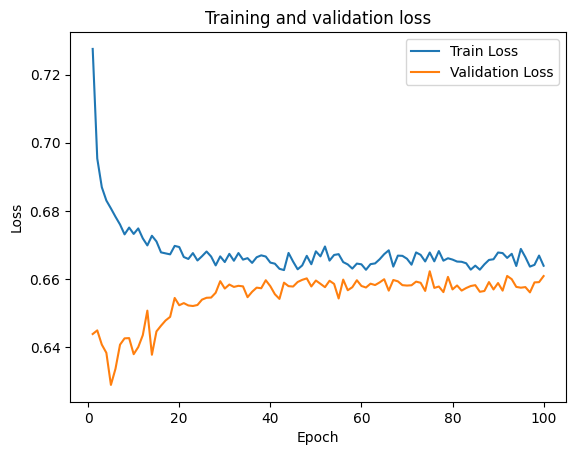

In [20]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

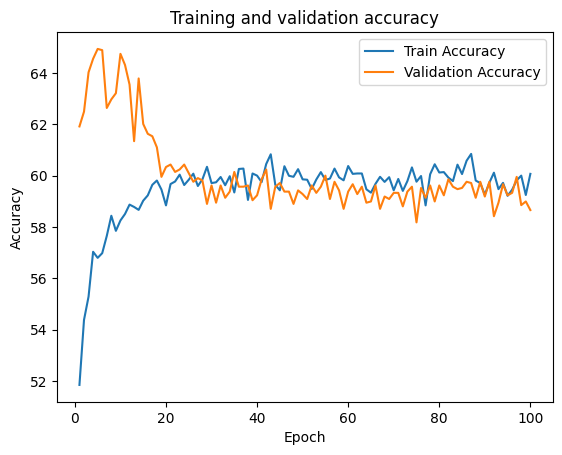

In [21]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [23]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1088
           1       0.56      0.66      0.60       997

    accuracy                           0.59      2085
   macro avg       0.59      0.59      0.59      2085
weighted avg       0.59      0.59      0.58      2085



In [24]:
print(confusion_matrix(y_test, y_pred_list))

[[563 525]
 [337 660]]


### Second Model

In [25]:
class BinaryNN2(nn.Module):
    def __init__(self):
        super(BinaryNN2, self).__init__()
        
        self.layer1 = nn.Linear(22, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.batchnorm1(self.layer1(inputs))
        x = self.leaky_relu(x)
        
        x = self.dropout(x)
        x = self.batchnorm2(self.layer2(x))
        x = self.leaky_relu(x)
        
        x = self.dropout(x)
        x = self.batchnorm3(self.layer3(x))
        x = self.leaky_relu(x)
        
        x = self.dropout(x)
        x = self.layer4(x)
        
        return x

In [26]:
model = BinaryNN2()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [27]:
history = {'train': {'Loss': [], 'Accuracy': []}, 'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*100}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(dataloaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(dataloaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

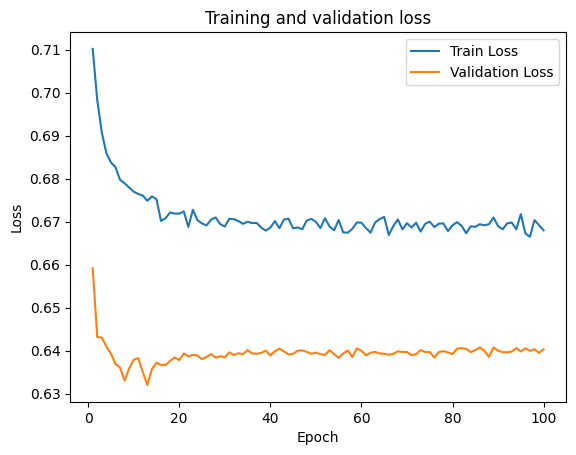

In [28]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

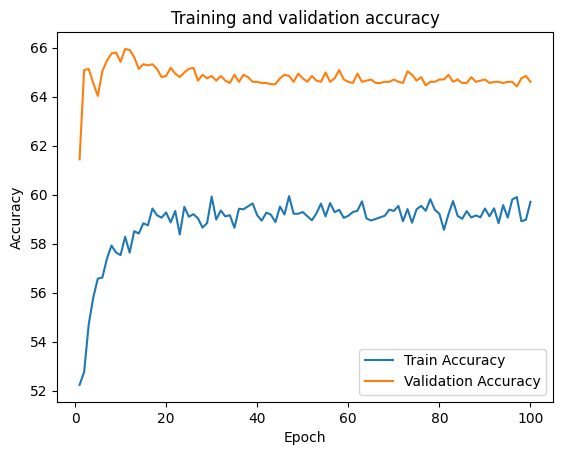

In [29]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [31]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1088
           1       0.62      0.68      0.65       997

    accuracy                           0.65      2085
   macro avg       0.65      0.65      0.65      2085
weighted avg       0.65      0.65      0.65      2085



In [32]:
print(confusion_matrix(y_test, y_pred_list))

[[674 414]
 [324 673]]


## Recurrent Neural Network

In [33]:
class SimpleRNN(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(SimpleRNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.gelu = nn.GELU()

    def forward(self, inputs):
        x = self.layer_norm(inputs)
        x = self.gelu(x)
        
        x, _ = self.RNN(x)
        x = self.dropout(x)
        
        return x

In [34]:
class BinaryRNN(nn.Module):
    
    def __init__(self, n_rnn_layers, rnn_dim, dropout=0.7):
        super(BinaryRNN, self).__init__()
        
        self.fc = nn.Linear(22, rnn_dim)
        
        self.recursive_layers = nn.Sequential(*[
            SimpleRNN(rnn_dim=rnn_dim, hidden_size=rnn_dim,
                      dropout=dropout, batch_first= i==0)
            for i in range(n_rnn_layers)
        ])
        
        self.fc1 = nn.Linear(rnn_dim, 22)
        self.batchnorm = nn.BatchNorm1d(22)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(22, 1)
        
    def forward(self, inputs):
        #x = self.fc(inputs)
        x = self.recursive_layers(inputs)
        
        x = self.batchnorm(self.fc1(x))
        x = self.gelu(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [35]:
model = BinaryRNN(2, 256)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [36]:
history = {'train': {'Loss': [], 'Accuracy': []}, 'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*100}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(dataloaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(dataloaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

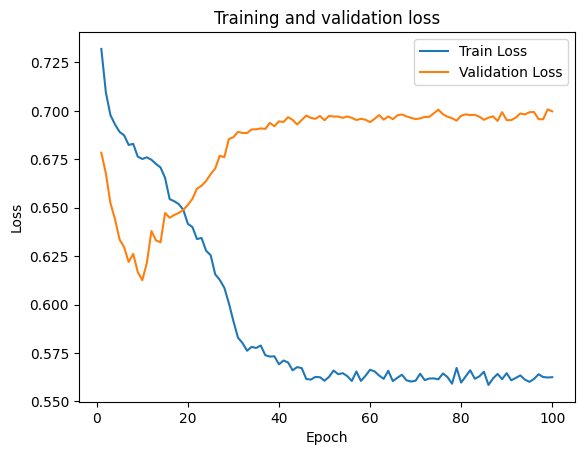

In [37]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

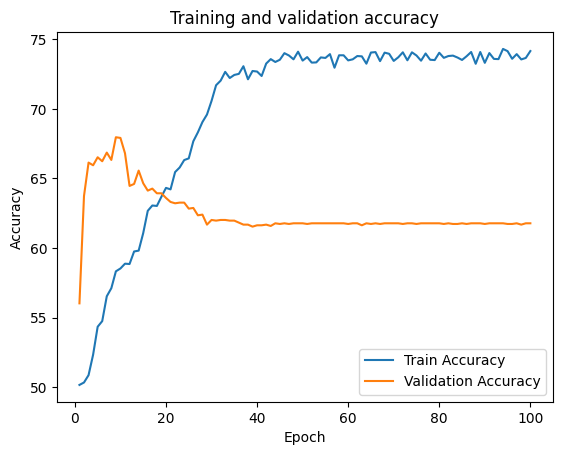

In [38]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
class BinaryLSTM(nn.Module):
    
    def __init__(self):
        super(BinaryLSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(22, 22, batch_first=True, dropout=0.5)
        
        self.fc1 = nn.Linear(22, 6)
        self.fc2 = nn.Linear(6, 1)
        
        self.leaky = nn.LeakyReLU()
        
        self.batchnorm = nn.BatchNorm1d(6)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, inputs):
        x, _ = self.lstm1(inputs)
        
        x = self.batchnorm(self.fc1(x))
        x = self.leaky(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [61]:
model = BinaryLSTM()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [62]:
history = {'train': {'Loss': [], 'Accuracy': []}, 'val': {'Loss': [], 'Accuracy': []}}

print(f'[{" "*100}] ({0:.2f}%)', end='\r')
for epoch in range(1, n_epochs+1):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            
        else:
            model.eval()
            
        epoch_loss = 0
        epoch_acc = 0
            
        for X_batch, y_batch in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        if phase ==  'train':
            exp_lr_scheduler.step()
            
        hist_loss = epoch_loss/len(dataloaders[phase])
        history[phase]['Loss'].append(hist_loss)
        hist_acc = epoch_acc/len(dataloaders[phase])
        history[phase]['Accuracy'].append(hist_acc)
    
    print(f'[{"="*(epoch)}{" "*(n_epochs-epoch)}] ({((epoch)/n_epochs)*100:.2f}%)', end='\r')

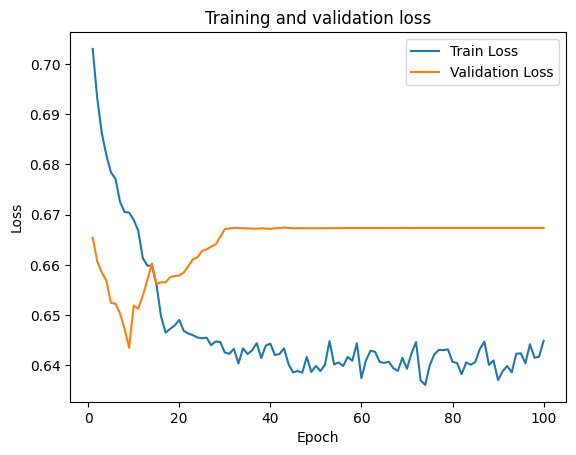

In [63]:
plt.plot(range(1, n_epochs+1), history['train']['Loss'], label='Train Loss')
plt.plot(range(1, n_epochs+1), history['val']['Loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

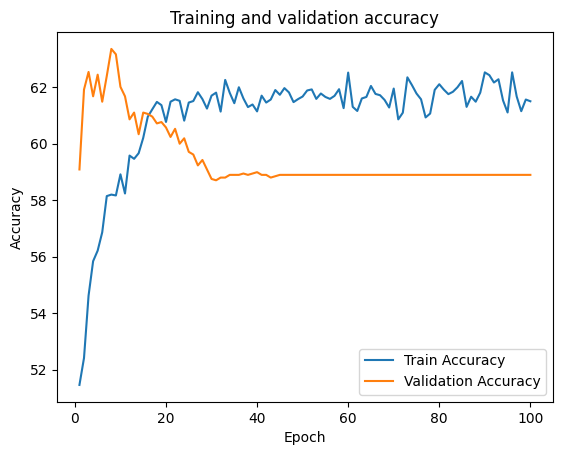

In [64]:
plt.plot(range(1, n_epochs+1), history['train']['Accuracy'], label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history['val']['Accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()